# What's the probability of getting a five-stars rating?

E-commerce rating prediction based on purchasing experiences and price factors


# Introduction

E-commerce is becoming more and more popular. Customers make their purchasing decision based on product ratings from other customers. Therefore, for sellers, how to get a high customer rating becomes the key to attracting customers. 

Customer ratings depend primarily on the purchasing experience (including product quality and service quality) and the actual cost (including product cost and service cost). The better the experience and the lower the price sellers can provide, the higher the customer rating. However, there is a paradox such that if sellers want to improve customer ratings by offering better products and services (e.g., faster delivery), then the high costs incurred by these will force them to raise prices, which may lead to a decrease in consumer ratings. Therefore, it is important to balance the quality of the product and service and the price that consumers have to pay.

In this project, I will train a machine learning model to predict customer ratings based on the quality of services and payment factors assuming that they cannot improve their predertermined product quality. I will use Brazilian e-commerce data from 2016 to 2018, which is a reliable dataset from https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce. By this model, sellers can predict the probability of different customer ratings given different online shopping experiences and price factors.

To be more specific, there is one outcome variable and six predictors in my model. The outcome variable is the customer rating, on a 1 to 5 scale. In general, I hypothesize that customer ratings can be predicted by purchasing experiences and payment factors. The purchasing services are indicated by the total delivery days, a dummy variable of delivery delay, and a categorical variable indicating the states' market size, which affects the convenience of the purchasing. There are three more price factors, including total payment value, freight value, and the number of payment installments.

# Data Cleaning

## import data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import axes
import seaborn as sns
from datetime import date
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression

In [2]:
data_path = '/Users/liuyifan/Desktop/eco225_dataset/'
customers_df = pd.read_csv(data_path + "olist_customers_dataset.csv")
geolocation_df = pd.read_csv(data_path + "olist_geolocation_dataset.csv")
order_items_df = pd.read_csv(data_path + "olist_order_items_dataset.csv")
order_payments_df = pd.read_csv(data_path + "olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv(data_path + "olist_order_reviews_dataset.csv")
orders_df = pd.read_csv(data_path + "olist_orders_dataset.csv")
products_df = pd.read_csv(data_path + "olist_products_dataset.csv")
sellers_df = pd.read_csv(data_path + "olist_sellers_dataset.csv")

## merge dataset

In [3]:
df = orders_df.merge(order_reviews_df, on = 'order_id')\
              .merge(customers_df, on = 'customer_id')\
              .merge(order_payments_df, on = 'order_id')\
              .merge(order_items_df, on = 'order_id')\
              .merge(products_df, on = 'product_id')\
              .merge(sellers_df, on = 'seller_id')

## feature engineering

I will create the following variables to support my predictions. 

a) Total delivery days. This variable denotes the gap between the date when customers made purchases and the date when the order has been delivered. 

b) Number of days the order came in advance of the estimated delivery date. This variable denotes the gap between the estimated delivery date and the actual date when the order has been delivered. I assume that delivery before estimated dates will not improve customer, whereas delivery delays will affect customer ratings negatively. Therefore, I create a delay indicator based on this variable. 

c) State market size indicators. State market size can reflect the convenience of the online shopping experience. In states with larger market sizes, customers are more likely to have fluent shopping experiences. Moreover, states market sizes can reflect its economic situation and educational level as well, which may affect customer ratings. The state market size can be decided by the number of purchasing from 2016 to 2018. The large state market size indicates that the state had 49000 or more customers between 2016 and 2018. The only large state is Sau Paulo. The small state market size indicates that the state had 5000 or fewer customers within two years. The remaining states are middle market size state.

In [4]:
# convert date variable to datetime object
date = ['order_purchase_timestamp', 'order_approved_at', 
        'order_delivered_carrier_date', 
        'order_delivered_customer_date', 
        'order_estimated_delivery_date', 
        'review_creation_date',
        'review_answer_timestamp', 'shipping_limit_date'
       ]
df[date] = df[date].apply(pd.to_datetime)

In [5]:
# total delivery days
total_delivery_days = []
for item in (df.order_delivered_customer_date - df.order_purchase_timestamp):
    total_delivery_days.append(item.days)
df['total_delivery_day'] = total_delivery_days

In [6]:
# delivery in advance
delivery_in_advance = []
for item in (df.order_estimated_delivery_date - df.order_delivered_customer_date):
    delivery_in_advance.append(item.days)
df['delivery_in_advance'] = delivery_in_advance

In [7]:
# delay indicator
for i, advance in enumerate(df.delivery_in_advance):
    if advance < 0:
        df.loc[i, 'delay'] = 1
    else:
        df.loc[i, 'delay'] = 0

In [8]:
# state market size
state_count = df.groupby('customer_state').count()
state_count.reset_index(inplace=True)
for i in range(len(state_count)):
    if state_count.loc[i, 'review_score'] >= 49000:
        state_count.loc[i, 'state_size'] = 2
    elif state_count.loc[i, 'review_score'] <= 5000:
        state_count.loc[i, 'state_size'] = 0
    else:
        state_count.loc[i, 'state_size'] = 1
to_merge = state_count.loc[:, ['customer_state', 'state_size']]
df = df.merge(to_merge, on='customer_state', how = 'outer')

# summary statistics

## variables selection

In this section, I will justify my predictors' selection by examining their absolute Pearson correlation with customer ratings. I mainly focus on three groups of variables. The first group is about price factors, including price, payment value, freight value, and the number of installments. The second group is about delivery services, including total delivery days and the number of delivery days in advance of the estimated. The third group is about other services, including product description length and the number of product description photos. 

In [9]:
interested_numeric = ['review_score', 'payment_installments', 
                      'payment_value', 'price', 'freight_value', 
                      'product_description_lenght', 'product_photos_qty', 
                      'delivery_in_advance', 'total_delivery_day'
                     ]
corr = df[interested_numeric].corr().round(3)
corr = corr.where(pd.np.tril(corr).astype(np.bool))

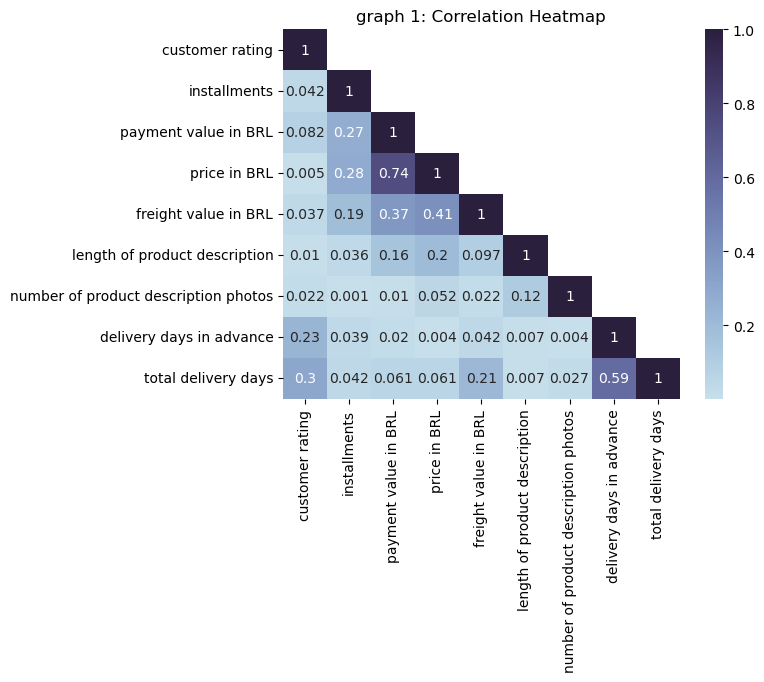

In [10]:
label = ['customer rating', 'installments', 'payment value in BRL',
        'price in BRL', 'freight value in BRL', 'length of product description',
        'number of product description photos', 'delivery days in advance', 
        'total delivery days'
        ]
corr = corr.abs()
color = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
sns.heatmap(corr, annot = True, cmap = color, xticklabels=label, yticklabels=label)
plt.title('graph 1: Correlation Heatmap')
plt.show() 

#### takeaway

a) Delivery services could be valuable predictors of the review score. The correlation between customer ratings and total delivery days is -0.3 and the correlation between customer ratings and delivery days in advance is 0.23. The longer the customers wait and the longer the actual delivery days than the estimated, the lower the review score could be. 

b) Price factors are also important. The correlation between customer ratings and payment value is - 0.08. The correlation between customer ratings and freight value is -0.04. The more expensive the products and delivery services are, the lower rating they will have.  Payment installments could also influence the review score. Longer periods of payment installments are correlated with a lower review score. The price itself is not correlated with customer ratings, so I will not keep it in my model. 

c) Surprisingly, other service variables are not that important. The correlations between customer ratings and the number of product photos and product description length are trivial. Therefore, I will not keep them in my model.

## summary statistics table

In [11]:
# only for variable of interests
interests = ['review_score', 'total_delivery_day', 
             'delay', 'payment_value',
             'freight_value', 'payment_installments',
             'state_size'
             ]
df_model = df[interests]
df_model = df_model.dropna()
df_model = df_model.reset_index(drop=True)

In [12]:
column = {'review_score': 'rating', 
          'total_delivery_day':'total delivery days',
          'payment_value': 'payment value in BRL', 
          'freight_value': 'freight value in BRL',
          'payment_installments': 'payment installments',
          'delay': 'delay indicator',
          'state_size': 'state market size'
         }
summary = df_model.describe()
summary.rename(columns=column, inplace=True)
summary.round(2)

,rating,total delivery days,delay indicator,payment value in BRL,freight value in BRL,payment installments,state market size
count,114858.00,114858.00,114858.00,114858.00,114858.00,114858.00,114858.00
mean,4.08,11.98,0.08,171.25,19.97,2.94,1.20
std,1.35,9.37,0.27,263.77,15.70,2.77,0.78
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.00,6.00,0.00,60.72,13.08,1.00,1.00
50%,5.00,10.00,0.00,108.00,16.28,2.00,1.00
75%,5.00,15.00,0.00,188.69,21.15,4.00,2.00
max,5.00,208.00,1.00,13664.08,409.68,24.00,2.00


#### takeaway

a) Customer rating: based on the summary statistics, the mean review score is 4.08, with more than 75% of customers giving a rating higher than 4.0. This is aligned with the customer's rating convention that customers tend to give 5 for satisfied, 4 for mediocre, 3 for dissatisfy, and rarely give 1 or 2. 

b) Price factors: payment value ranges from 0, because of discount, to 13664.08, with a mean 171.25, in Brazillian real. Freight value ranges from 0 to 409.68, with most of them smaller than 20. The ratio between freight value and payment value is more than 1 to 10, indicating that freight value is not a large proportion of total expenditure. It is rare to have a large period of installments. On average, people have 2.77 periods. 

c) Delivery experience: total delivery day ranges from 0 to 208 with 12 days on average. The extremely long delivery days could be outliers that are probably because of the item lost. Delivery services are stable, with only 8 percent of the services being delayed.

# Exploratory Analysis

## outcome: customer ratings

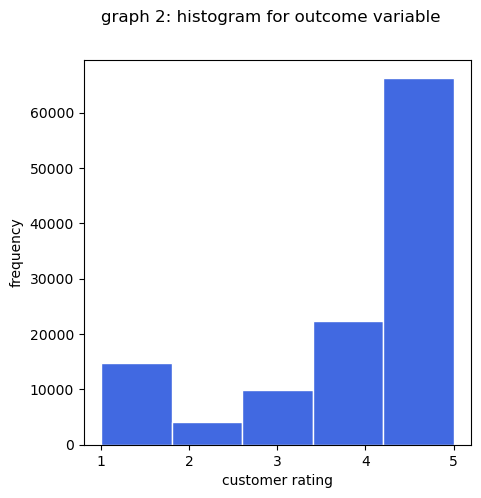

In [13]:
fig, ax = plt.subplots()
sub = df['review_score']
sub.plot(kind='hist', color='royalblue',edgecolor='white', 
         figsize=(5, 5), ax=ax, legend=False, bins=5)
    
ax.set_xticks([1,2,3,4,5])
ax.set_xlabel('customer rating')
ax.set_ylabel('frequency')
fig.suptitle('graph 2: histogram for outcome variable')
plt.show()

#### takeaway

The distribution of customer ratings is negatively skewed. There are far more 5-star ratings than others. This result is as expected because it is aligned with customer rating custom. 5-star ratings indicate satisfaction, 4-star ratings indicate indifference, and 1-stars is terrible. They rarely give 2 or 3 stars ratings. This distribution is informative when training my model. It will be more helpful to set the probability threshold of predicting each customer rating accordingly.

## predictors: delivery experiences

In this section, I will present the distribution of delivery experiences variables. Then, I will examine the relationship between customer ratings and delivery experiences using boxplots. The reason for choosing boxplots is that customer rating is a discrete random variable. Scatter plots cannot capture its variation well. To balance the number of observations in each rating, I randomly select 1000 samples from each level of customer rating.

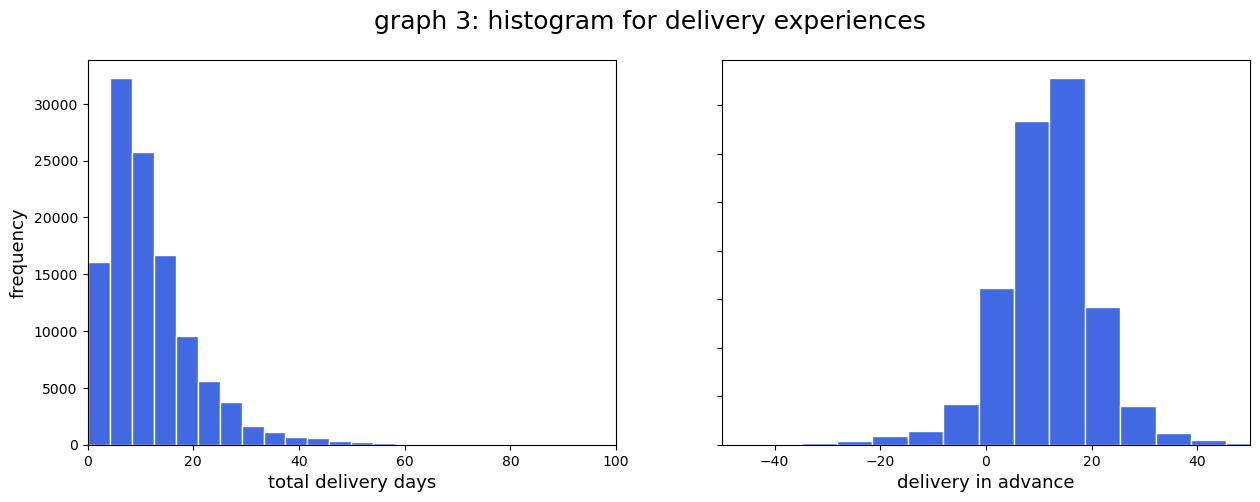

In [14]:
column = ['total_delivery_day', 'delivery_in_advance']
fig, ax = plt.subplots(1, 2)
for i, column in enumerate(column): 
    sub = df[column]
    bins = [50, 50]
    sub.plot(kind='hist', color='royalblue',edgecolor='white', 
             figsize=(15, 5), ax=ax[i], legend=False,
             sharey=True, bins=bins[i])

ax[0].set_xlabel('total delivery days', fontsize=13)
ax[0].set_ylabel('frequency', fontsize=13)
ax[0].set_xlim(0, 100)
ax[1].set_xlabel('delivery in advance', fontsize=13)
ax[1].set_xlim(-50, 50)
fig.suptitle('graph 3: histogram for delivery experiences', fontsize=18)
plt.show() 

#### takeaway

a) The distribution of total delivery days is positively skewed. Most delivery services were completed within 10 days, but there are cases of extremely long delivery services.

b) The distribution of delivery days in advance is nearly normal, with a mean of around 10 days. Most delivery services were completed earlier than expected, but there is still 25 percent of late deliveries. 

In [15]:
df_sample = df[['review_score', 'total_delivery_day', 'delivery_in_advance', 
          'payment_value', 'freight_value', 'payment_installments']]
df_sample = df_sample.dropna().reset_index(drop=True)
df_sample = df_sample.groupby('review_score')
sample = df_sample.sample(n=1000, random_state=2)
sample = sample.reset_index(drop=True)

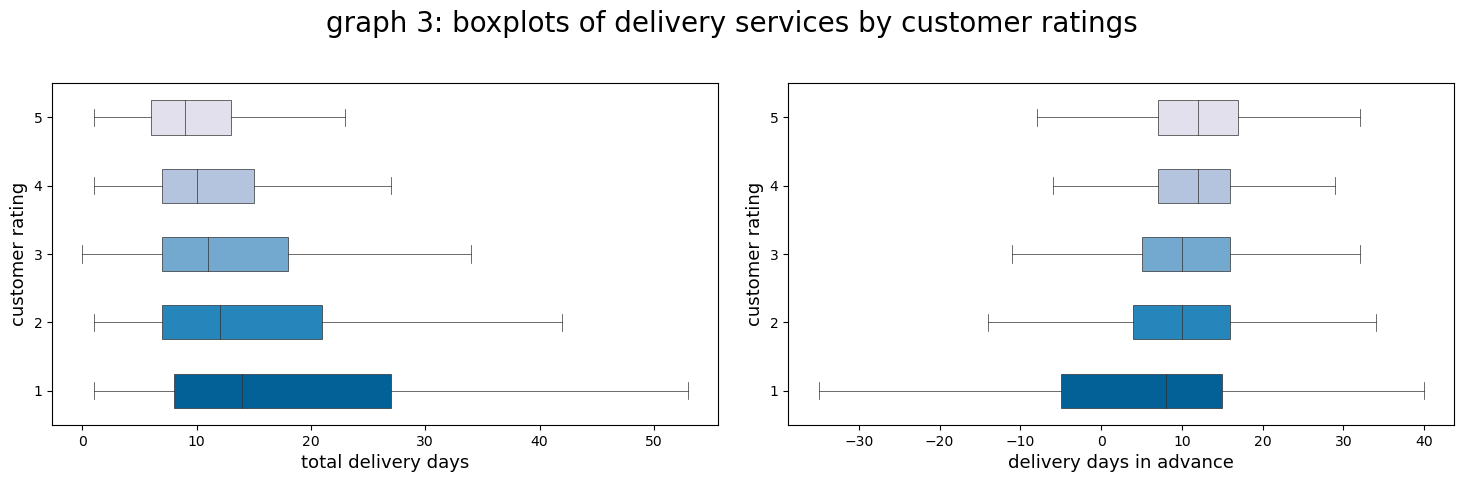

In [16]:
column = ['total_delivery_day', 'delivery_in_advance']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i, column in enumerate(column):
    sub = sample[['review_score', column]]
    sns.boxplot(data=sub, y='review_score', 
                x=column, orient='h',
                palette='PuBu', saturation=1, linewidth=0.5,
                width=0.5, order=[5, 4, 3, 2, 1], showfliers=False,
                ax=ax[i])
    ax[i].set_ylabel('customer rating', fontsize=13)
ax[0].set_xlabel('total delivery days', fontsize=13)
ax[1].set_xlabel('delivery days in advance', fontsize=13)
fig.suptitle('graph 3: boxplots of delivery services by customer ratings',
           fontsize=20)
fig.tight_layout(pad=2)
plt.show()

#### takeaway

a) There is a strong negative relationship between total delivery days and customer ratings. A long delivery period is a strong indicator of low customer ratings.

b) The relationship between delivery days in advance and ratings is positive. This trend is more obvious in the case of delivery delays. The delivery delay is a strong indicator of low customer ratings. This trend supports my decision of keeping the delivery delay indicator in my model.

## predictors: price factors 

In this section, I will present the distribution of price factors variables. Then, I will examine the relationship between customer ratings and price factors using boxplots. 

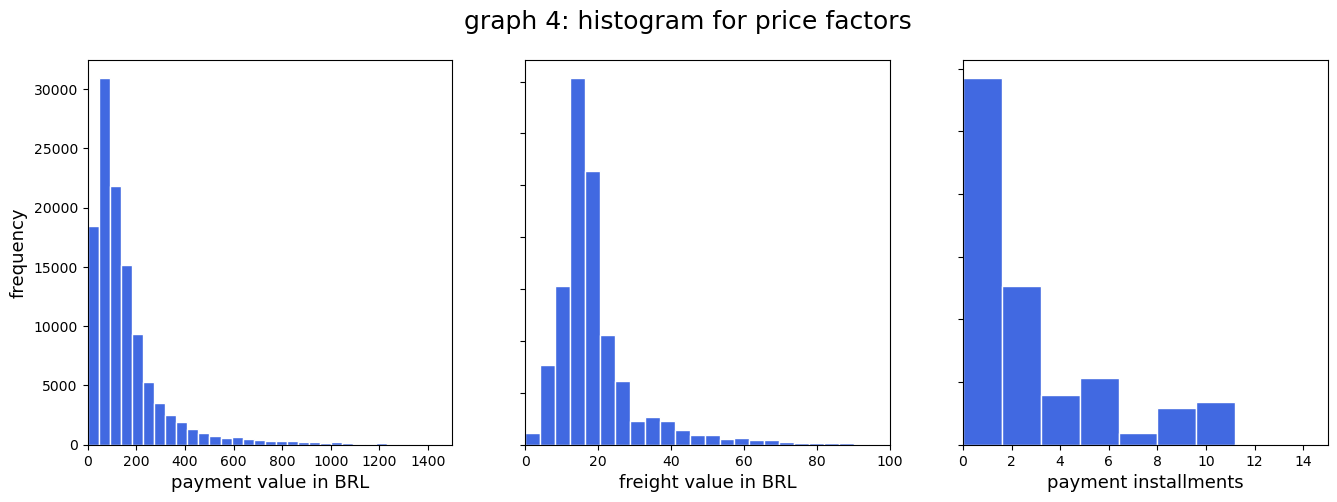

In [17]:
column = ['payment_value', 'freight_value',
         'payment_installments']

fig, ax = plt.subplots(1, 3)
for i, column in enumerate(column): 
    sub = df[column]
    bins = [300, 100, 15]
    sub.plot(kind='hist', color='royalblue',edgecolor='white', 
             figsize=(16, 5), ax=ax[i], legend=False,
             sharey=True, bins=bins[i])

ax[0].set_xlabel('payment value in BRL', fontsize=13)
ax[0].set_xlim(0, 1500)
ax[1].set_xlabel('freight value in BRL', fontsize=13)
ax[1].set_xlim(0, 100)
ax[2].set_xlabel('payment installments', fontsize=13)
ax[2].set_xlim(0, 15)
ax[0].set_ylabel('frequency', fontsize=13)
fig.suptitle('graph 4: histogram for price factors', fontsize=18)
plt.show() 

#### takeaway

The distributions of price factors are all positively skewed. In general, customers spent less than 200 BRL in total, less than 20 BRL in delviery services, and have the number of installments within 4 periods.

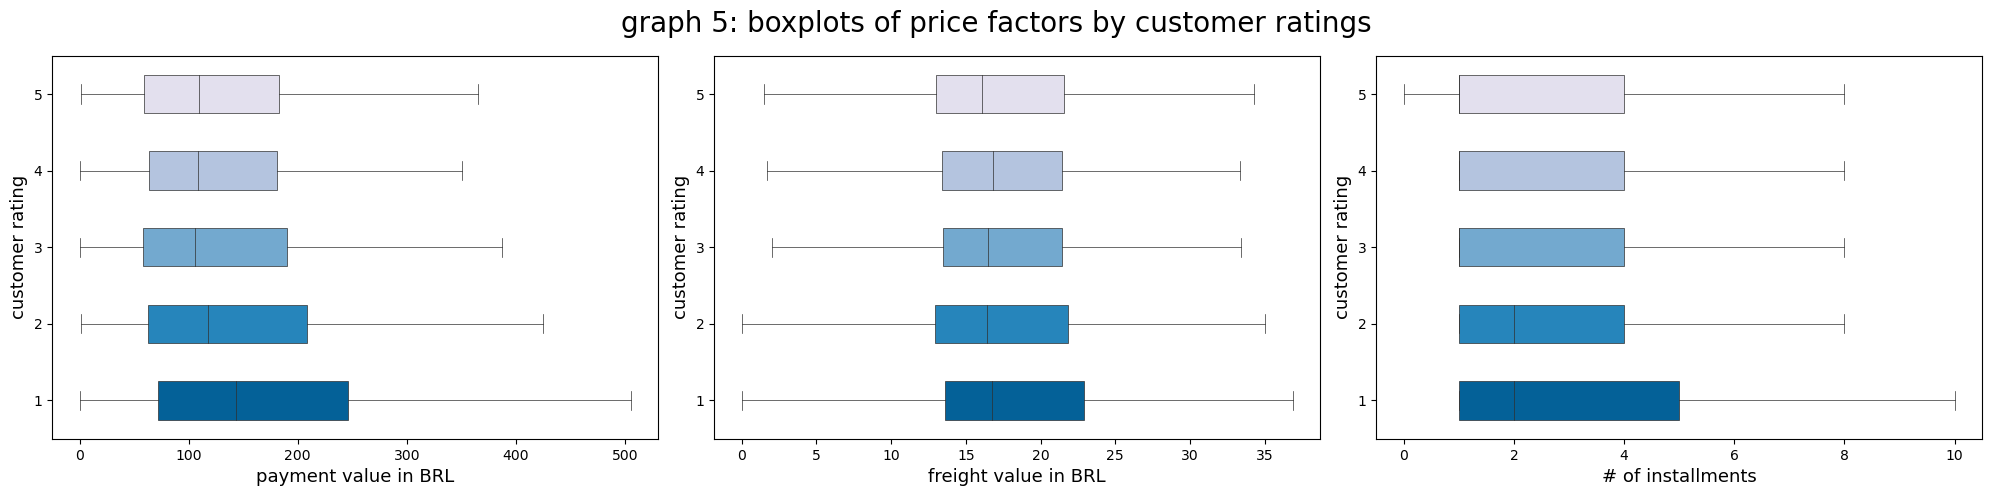

In [18]:
column = ['payment_value', 'freight_value',
         'payment_installments']

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, column in enumerate(column):
    sub = sample[['review_score', column]]
    sns.boxplot(data=sub, y='review_score', 
                x=column, orient='h',
                palette='PuBu', saturation=1, linewidth=0.5,
                width=0.5, order=[5, 4, 3, 2, 1], showfliers=False,
                ax=ax[i])
    ax[i].set_ylabel('customer rating', fontsize=13)

ax[0].set_xlabel('payment value in BRL', fontsize=13)
ax[1].set_xlabel('freight value in BRL', fontsize=13)
ax[2].set_xlabel('# of installments', fontsize=13)
fig.suptitle('graph 5: boxplots of price factors by customer ratings', fontsize=20)
fig.tight_layout(pad=1)
plt.show()

#### takeaway

a) It is obvious that an extremely high payment value is associated with a low rating. However, a low payment value is not an indicator of a high rating. This makes sense because when people pay more, they will expect more, but when they pay less, they will not expect less.

b) Products without 5-star ratings tend to have a higher median freight value than products with 5-star ratings. This might be because when people self-select a cheaper delivery, it means they do not care about the quality of delivery so much and will be more generous.

c) It is obvious that a higher rating score is associated with fewer payment installments. Payment installments are related to unobservable such as purchasing habits and individuals' financial situations. These factors can influence customer ratings. 

## Qualitative Variables

In this section, I will examine the relationship between state market size and quantitative variables. I hypothesize that the larger the state market size, the more convenient the online shopping will be. The convenience can be defined by shorter delviery period and less freight value. However, there are far more observations in the large state than the small state. For a more balanced standard deviation and visualization, I decide to randomly selected 1000 observations from each state market size.

After that, I will present the summary table grouped by state size and use boxplot to depict the relationship between each quantitative variables and state market size.

In [19]:
sample2 = df.groupby('state_size').sample(n=1000, random_state=1)
sample2 = sample2[['review_score', 'state_size', 'total_delivery_day', 
         'payment_value', 'freight_value',
         'payment_installments']]
sample2.reset_index(drop=True)
summary_by_type = sample2.groupby('state_size').mean()
column = {'review_score': 'rating', 
          'total_delivery_day':'total delivery days',
          'payment_value': 'payment value in BRL', 
          'freight_value': 'freight value in BRL',
          'payment_installments': 'payment installments'}
index = {2: 'state w/ large market size',
         1: 'state w/ midium market size',
         0: 'state w/ small market size'}
summary_by_type.rename(columns=column, index=index, inplace=True)
summary_by_type

,rating,total delivery days,payment value in BRL,freight value in BRL,payment installments
state_size,,,,,
state w/ small market size,3.945,17.060976,195.83370,26.91535,3.173
state w/ midium market size,3.963,13.137335,170.69254,20.53815,3.076
state w/ large market size,4.150,8.089990,153.73388,15.08994,2.697


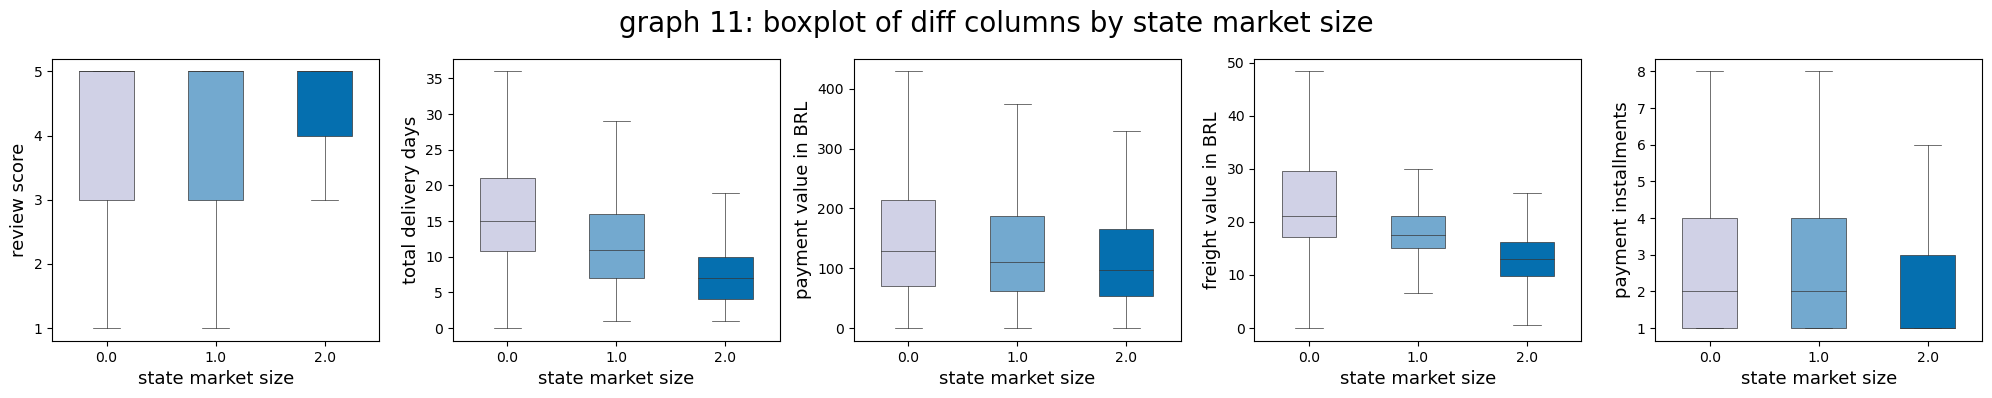

In [20]:
column = ['review_score', 'total_delivery_day', 
         'payment_value', 'freight_value',
         'payment_installments']

fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, column in enumerate(column):
    sub = sample2[['state_size', column]]
    sns.boxplot(data=sub, y=column, 
                x='state_size', orient='v',
                palette='PuBu', saturation=1, linewidth=0.5,
                width=0.5, showfliers=False, ax=ax[i])
    ax[i].set_xlabel('state market size', fontsize=13)
ax[0].set_ylabel('review score', fontsize=13)
ax[0].set_yticks([1,2,3,4,5])
ax[1].set_ylabel('total delivery days', fontsize=13)
ax[2].set_ylabel('payment value in BRL', fontsize=13)
ax[3].set_ylabel('freight value in BRL', fontsize=13)
ax[4].set_ylabel('payment installments', fontsize=13)

fig.suptitle('graph 11: boxplot of diff columns by state market size', fontsize=20)
fig.tight_layout(pad=1)
plt.show()

#### takeaway

Based on the summary table, states with large market size on average have 0.16 higher customer ratings than the middle states, and even more than the small states. This difference are likely to be a statistically significant difference (given that our sample size is large). This significant difference is likely to be driven by shorter delivery days and less freight value. The above statements are more obvious in graph 11. It is clear that the large market size states have a more negatively-skewed distribution. Some unobservables may also related to state market size, such as economic development and education quality. They can affect review score. Therefore, I decide to keep this variable for future use.

## Geolocation Data

In this section, I will focus on maps and geolocation data. Specifically, I will aggregate the my variable of interests at a state level to explore trends and relationships. The reason for a state-level aggregation is that it allows enough observations for further analysis.

In [43]:
# import necessary packages
import geobr
import geopandas as gpd
states = geobr.read_state(year=2016)

In [44]:
# create a gdf with number of customers, sellers, and average ratings
# aggregated in states level
df_state = df.groupby('customer_state')[['order_id']].count()
df_state.reset_index(inplace=True)
df_seller = df.groupby('seller_state')[['seller_id']].count().reset_index()
df_rating = df.groupby('customer_state')[['review_score']].mean().reset_index()
df_state = df_state.merge(df_seller, left_on='customer_state',
                          right_on='seller_state')
df_state = df_state.merge(df_rating, on='customer_state')
df_state = df_state.merge(states, left_on='customer_state',
                          right_on='abbrev_state')
df_state = df_state.drop(columns=['seller_state', 'abbrev_state'])
df_state = df_state.rename(columns={'seller_id':'seller_number', 
                                    'customer_state':'state', 
                                    'order_id': 'customer_number'})
gdf = gpd.GeoDataFrame(df_state, geometry="geometry")

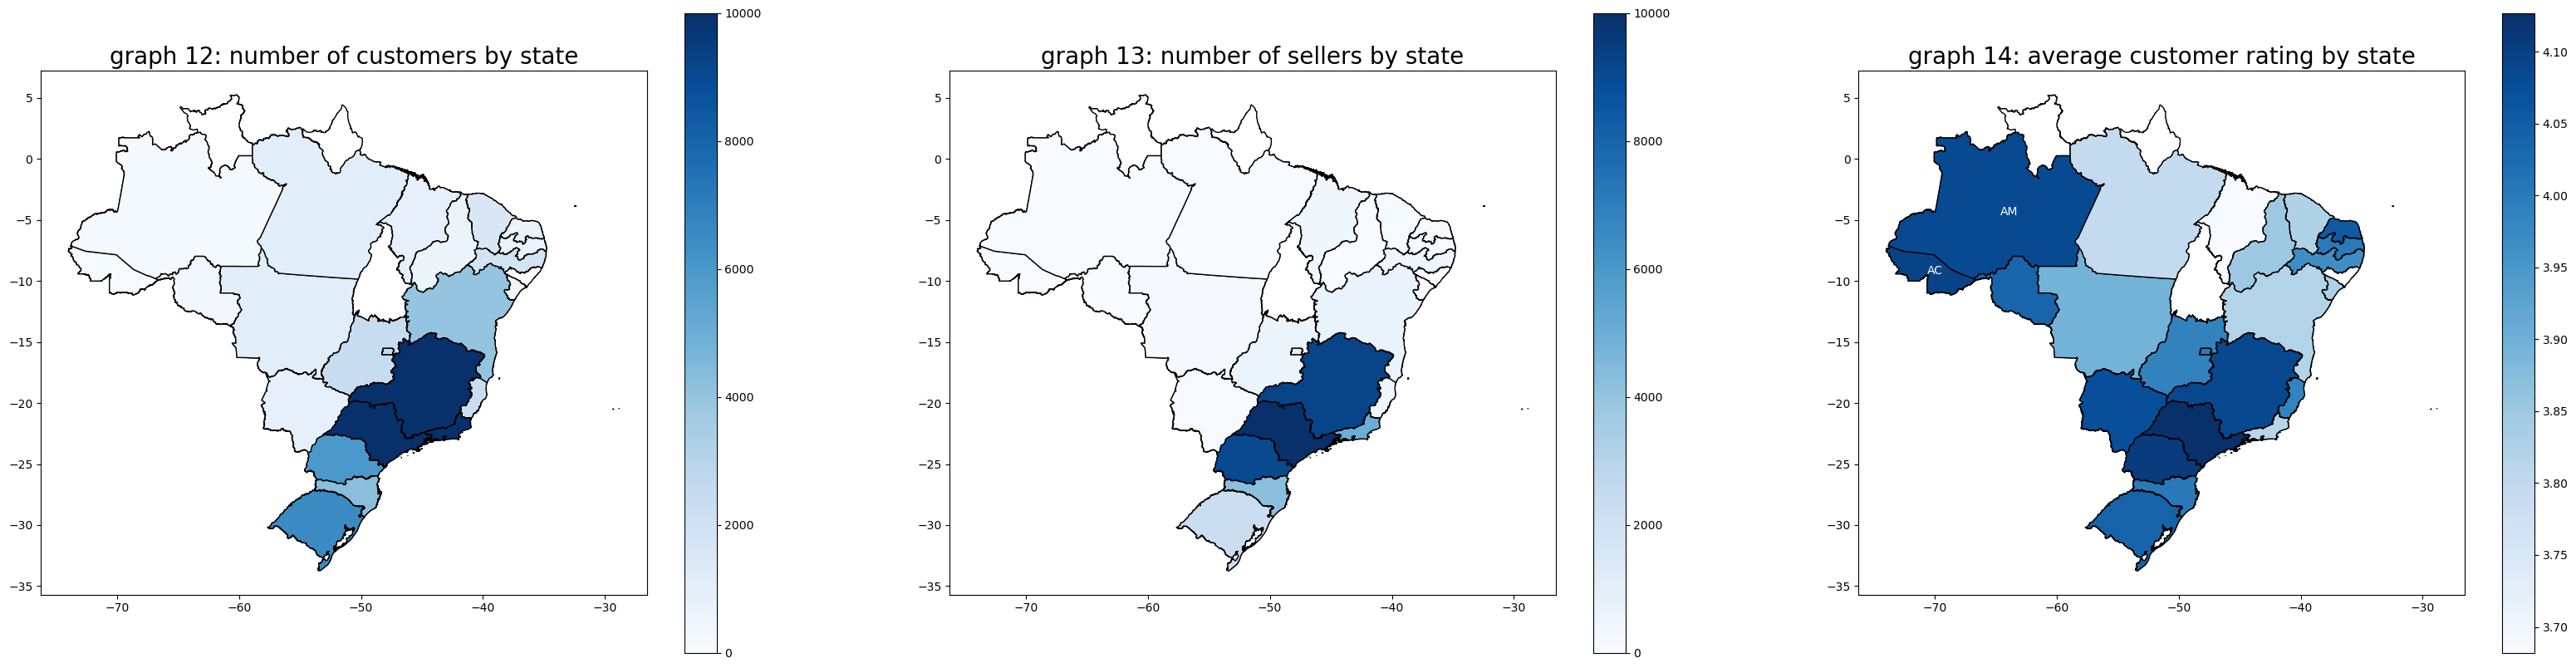

In [45]:
fig, gax = plt.subplots(1, 3, figsize=(40,10))
for i in range(3):
    gax[i] = states.plot(ax=gax[i], edgecolor='black', 
                         color='white')
gdf.plot(ax=gax[0], column='customer_number',
         edgecolor='black', cmap='Blues', 
         vmin=0, vmax=10000, legend=True)
gdf.plot(ax=gax[1], column='seller_number', 
         edgecolor='black', cmap='Blues', 
         vmin=0, vmax=10000, legend=True)
gdf.plot(ax=gax[2], column='review_score', 
         edgecolor='black', cmap='Blues', 
         legend=True)
gax[0].set_title('graph 12: number of customers by state',
                 fontsize=20)
gax[1].set_title('graph 13: number of sellers by state',
                 fontsize=20)
gax[2].set_title('graph 14: average customer rating by state',
                 fontsize=20)
gax[2].annotate('AC', xy=(-71, -9.8), xytext=(4,4),
                textcoords='offset points', color='white')
gax[2].annotate('AM', xy=(-65, -5), xytext=(4,4),
                textcoords='offset points', color='white')
plt.show()

#### takeaway

a)Based on graphs 12 and 13, I found an extremely large number of sellers and customers in south Brazil due to the unbalanced economic development in Brazil. I hypothesize that this imbalance may lead to different customer ratings because i). more sellers and customers will result in a more convenient shopping experience; ii). the underlying imbalance of economic development will lead to different education and purchasing behaviour. 

b)Graph 14 supports my hypthesis. It suggests that compared to the states with less sellers and customers, the states with more sellers and customers have higher average customer ratings. Amazonas (AM) and Acre (AC) are two exceptions where there are few sellers and customers but have high average rating. However, I realized that they only have 170 and 95 observations, which are too small to draw a conclusion.

c)These graphs suggest that the state is a valuable predictor of customer rating. Knowing customer states provide distinct information like the number of sellers and customers, rating history, and even the economic development. Therefore, I will include some state indicators to my model for a better prediction.

# Modeling

In this section, I will apply different classification models to predict customer ratings. Predictors include total delivery days, a binary indicator of delivery delay, payment value, freight value, number of payment installments, and state market size indicators. To simply the model, I convert the outcome variable to a binary variable, where 1 denotes customer ratings of 4 or 5, whereas 0 denotes customer ratings lower than 3.

I will clean my data before applying the machine learning model. First, I will split my data train data(80%) and test data(20%). Then, I will standardize my data to ensure that they all follow standard normal distributions. 

In [21]:
# create new binary outcome variable
ml_model = df_model.copy()
for i, score in enumerate(ml_model.review_score):
    if score >= 4:
        ml_model.loc[i, 'review'] = 1
    else:
        ml_model.loc[i, 'review'] = 0
ml_model.drop(columns=['review_score'], inplace=True)

In [22]:
# split train / test data
X = ml_model.iloc[:, : -1].values
y = ml_model.iloc[:, -1].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# transform data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Linear Regression

In [23]:
# linear regression
model5 = LinearRegression()
model5.fit(X_train, y_train)
y_pred = model5.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i] >= sum(y_test)/len(y_test):
        y_pred[i] = 1
    else:
        y_pred[i] = 0
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
print('linear', acc, auc)

linear 0.7232282779035347 0.6188469273586564


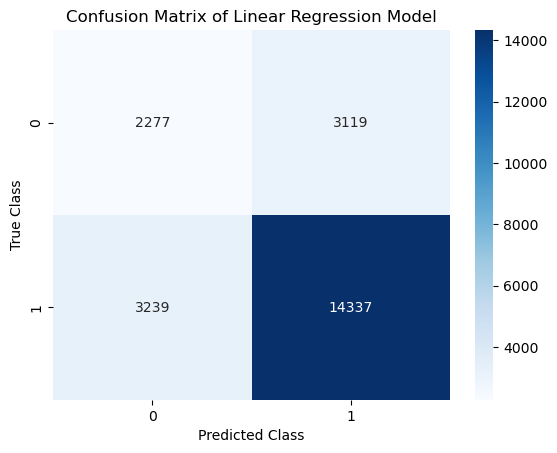

In [24]:
fig = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix of Linear Regression Model')
plt.show()

#### takeaway

Multiple linear regression is the most straightforward model, which has many restrictions to the slope coefficient. This model has an overall accuracy score of 0.72 and an AUC (area under the ROC curve) of 0.62. An AUC of 0.62 suggests that this model is better than a random guess with 0.5 AUC, but it is still not an accurate model.

Based on its confusion matrix, this model has a recall rate of 0.82 (true positive out of positive). However, this model also has a false positive rate of 0.578 (false positive out of negative). While this model did a good job in predicting a 4 or 5 stars ratings, but it is not good at identifying low ratings. I have to pay attention to this drawback because low ratings are more noteworthy to sellers.

## Logistic Regression

In [25]:
# logistic regression
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(random_state=0)
model1.fit(X_train, y_train)
y_pred = model1.predict_proba(X_test)[::, 1]
for i in range(len(y_pred)):
    if y_pred[i] >= sum(y_test)/len(y_test):
        y_pred[i] = 1
    else:
        y_pred[i] = 0
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
print('logit', acc, auc)

logit 0.7273637471704684 0.6197515025712331


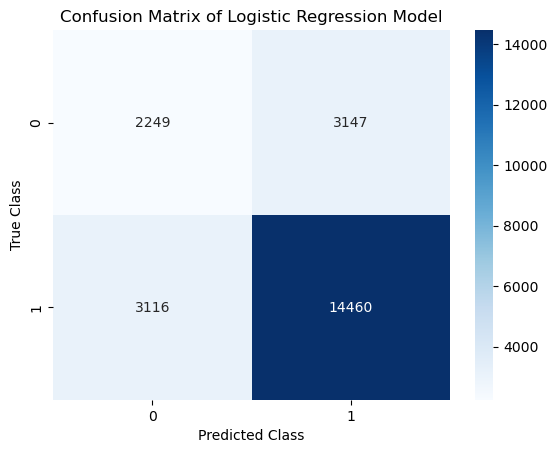

In [26]:
fig = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix of Logistic Regression Model')
plt.show()

#### takeaway

Logistic regression did a slightly better job than linear regression, with a test accuracy of 0.73 and an AUC of 0.62. However, this is not an accurate model as a whole because it is still a restrictive model.

The logistic regression model also has a better TPR and FPR than the linear model. However, its FPR is still higher than 50%, indicating that it is not good at discriminating low ratings.

In [27]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier(random_state=0)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
print('tree', acc, auc)

tree 0.7559202507400313 0.6692357207230157


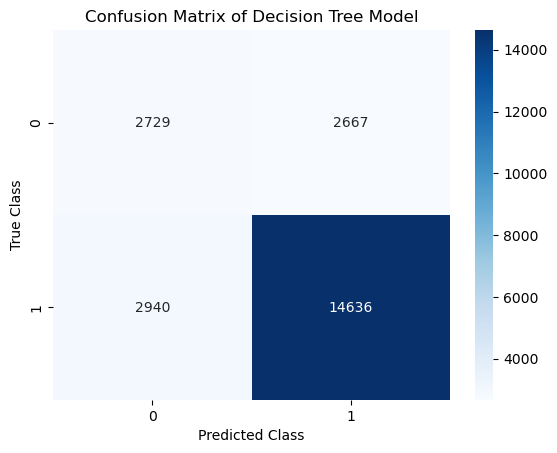

In [28]:
fig = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix of Decision Tree Model')
plt.show()

#### takeaway

The decision tree model is much better than the linear regression model because it is more flexible and can better capture the true relationship. The test accuracy is 0.76 and the AUC is 0.67. 

Its confusion matrix can reflect the improvement better. The decision tree model has a recall rate of 0.83 (higher than linear and logistic regression) while keeping a low false positive rate of 0.49 (lower than 0.5). This is so far the best balance between TPR and FPR. 

In [29]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier(random_state=0)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
print('forest', acc, auc)

forest 0.8258749782343723 0.6962011721287165


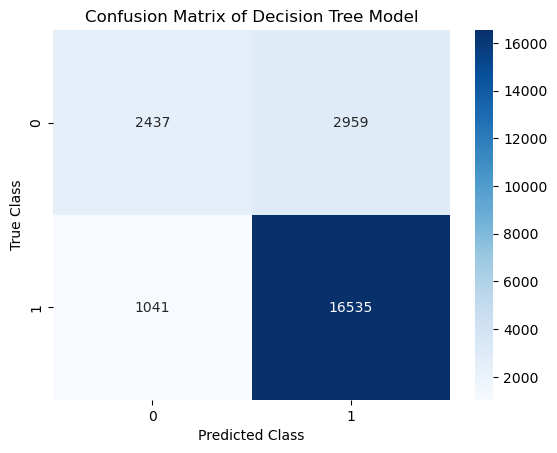

In [30]:
fig = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix of Decision Tree Model')
plt.show()

#### takeaway

The random forest model is a more advanced version of the decision tree model, which is less sensitive to overfitting. This is reflected by its high accuracy(0.83) and AUC(0.70).

Its recall rate is 0.94. This model is really accurate in identifying high customer ratings. However, its false positive rate is higher than 0.5 (but lower than the linear and logistic regression model). One way to improve is by adjusting the hyperparameter. I can lower its TPR in exchange for a lower FPR.

In [31]:
# knn
from sklearn.neighbors import KNeighborsClassifier
lst = []
for i in range(1, 21):
    model4 = KNeighborsClassifier(n_neighbors=i)
    model4.fit(X_train, y_train)
    y_pred = model4.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    lst.append((i, acc, auc))
lst

[(1, 0.7607086888385861, 0.66909010720529),
 (2, 0.68687967960996, 0.6611042654364248),
 (3, 0.7678042834755354, 0.6335295569502587),
 (4, 0.7376806547100818, 0.6417764275565474),
 (5, 0.7791659411457427, 0.6241947709542597),
 (6, 0.7620146265018283, 0.6308376153478377),
 (7, 0.7829531603691451, 0.6131207205863647),
 (8, 0.7733762841720355, 0.6194480022458012),
 (9, 0.7873498171687271, 0.6088662752935214),
 (10, 0.7804283475535434, 0.613525570450709),
 (11, 0.7895699111962389, 0.6053084762799059),
 (12, 0.7844332230541529, 0.6092077342477595),
 (13, 0.7910935051366882, 0.602258711336606),
 (14, 0.7888734111091764, 0.6070365639444313),
 (15, 0.7934006616750827, 0.6017116220548744),
 (16, 0.7897005049625632, 0.6032105661301734),
 (17, 0.7933135991641999, 0.5981229921994173),
 (18, 0.7926170990771374, 0.6032543872583174),
 (19, 0.7945324743165593, 0.5979563327308315),
 (20, 0.7936618492077312, 0.6011759625380387)]

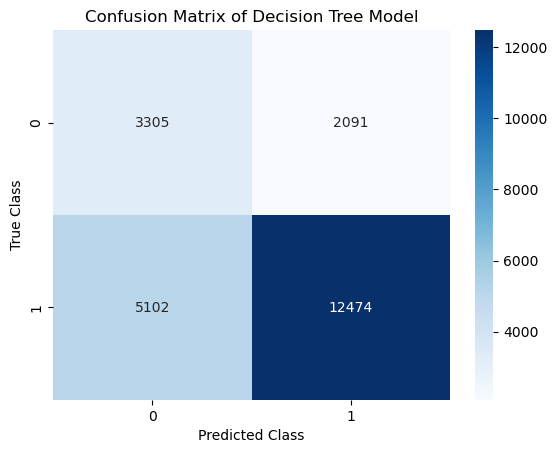

In [32]:
model4 = KNeighborsClassifier(n_neighbors=2)
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

fig = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix of Decision Tree Model')
plt.show()

#### takeaway

I tried multiple hyperparameters for the KNN model. The model accuracy and the AUC are optimized at different level of hyperparameter k. Since I want a better balance between TPR and FPR, so I choose a low level of k for a higher AUC (0.67). 

Based on the confusion matrix, the KNN model has a recall rate of 0.71. This model is not good at identifying high customer ratings. However, it is really good at identifying low customer ratings, with a FPR of 0.39. Since it is important to identify a low customer ratings (which means the sellers should take action), a low FPR achieved by the KNN model is neccesary. 

## Model Visualization

In [33]:
# create a new dataset for plot
ml_plot = ml_model[['total_delivery_day', 'payment_value', 'review']]
filter1 = ml_plot.total_delivery_day <= 50
ml_plot = ml_plot[filter1]
filter2 = ml_plot.payment_value <= 1000
ml_plot = ml_plot[filter2]

# split
X = ml_plot.iloc[:, : -1].values
y = ml_plot.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# transform data
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## logistic regression

In [34]:
# prediction
model_plot = LogisticRegression(random_state=0)
model_plot.fit(X_train, y_train)
y_pred = model_plot.predict(X_test)

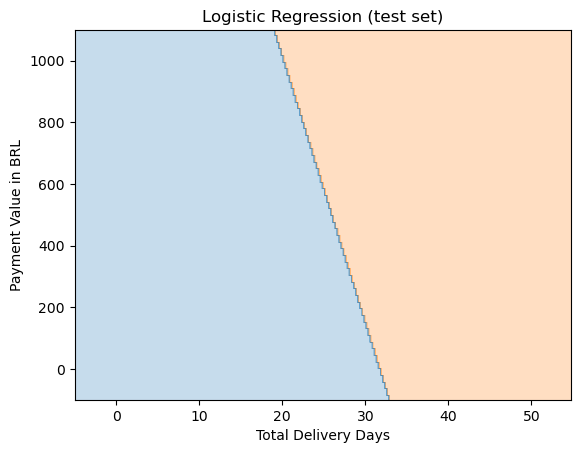

In [35]:
from matplotlib.colors import ListedColormap
X_set, y_set = sc.inverse_transform(X_test), y_test
x1 = np.arange(start = X_set[:, 0].min() - 5,
               stop = X_set[:, 0].max() + 5 ,
               step = 0.25)
x2 = np.arange(start = X_set[:, 1].min() - 100,
               stop = X_set[:, 1].max() + 100,
               step = 0.25)
X1, X2 = np.meshgrid(x1, x2)
a = ListedColormap(('tab:orange', 'tab:blue'))
plt.contourf(X1, X2,
             model_plot.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.25, cmap = a)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
plt.title('Logistic Regression (test set)')
plt.xlabel('Total Delivery Days')
plt.ylabel('Payment Value in BRL')
plt.show()

## Decision Tree

In [36]:
# prediction
model_plot = DecisionTreeClassifier(random_state=0)
model_plot.fit(X_train, y_train)
y_pred = model_plot.predict(X_test)

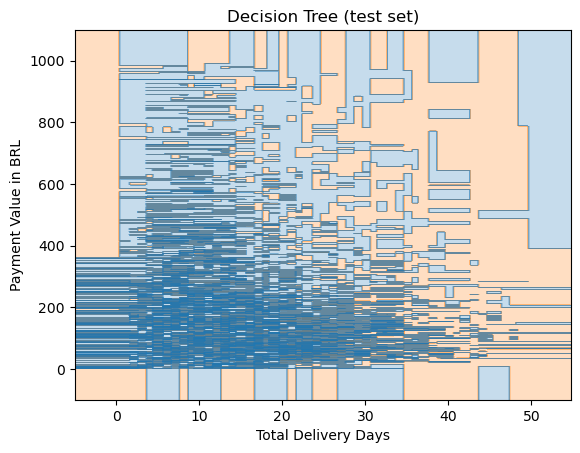

In [37]:
X_set, y_set = sc.inverse_transform(X_test), y_test
x1 = np.arange(start = X_set[:, 0].min() - 5,
               stop = X_set[:, 0].max() + 5 ,
               step = 0.25)
x2 = np.arange(start = X_set[:, 1].min() - 100,
               stop = X_set[:, 1].max() + 100,
               step = 0.25)
X1, X2 = np.meshgrid(x1, x2)
a = ListedColormap(('tab:orange', 'tab:blue'))
plt.contourf(X1, X2,
             model_plot.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.25, cmap = a)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
plt.title('Decision Tree (test set)')
plt.xlabel('Total Delivery Days')
plt.ylabel('Payment Value in BRL')
plt.show()

## KNN

In [38]:
model_plot = KNeighborsClassifier(n_neighbors=17)
model_plot.fit(X_train, y_train)
y_pred = model_plot.predict(X_test)

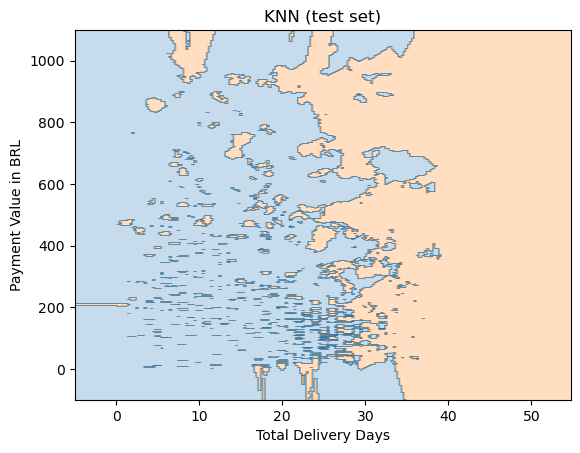

In [39]:
X_set, y_set = sc.inverse_transform(X_test), y_test
x1 = np.arange(start = X_set[:, 0].min() - 5,
               stop = X_set[:, 0].max() + 5 ,
               step = 0.25)
x2 = np.arange(start = X_set[:, 1].min() - 100,
               stop = X_set[:, 1].max() + 100,
               step = 0.25)
X1, X2 = np.meshgrid(x1, x2)
a = ListedColormap(('tab:orange', 'tab:blue'))
plt.contourf(X1, X2,
             model_plot.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.25, cmap = a)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
plt.title('KNN (test set)')
plt.xlabel('Total Delivery Days')
plt.ylabel('Payment Value in BRL')
plt.show()